In [1]:
# builtin
import os,warnings,sys
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import pandas as pd
import numpy as np
import matplotlib as mtpl
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import decomposition
from sklearn import manifold
import seaborn as sns
%matplotlib inline

In [2]:
# warnings.filterxarnings('ignore'ou once
warnings.filterwarnings(action='ignore')
# nous désactivons les messages d'erreur
pd.set_option('display.max_columns', 200)
# Versions
print('Version des librairies utilisées :')

print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Python                : ' + sys.version)
print('Matplotlib            : ' + mtpl.__version__)
print('Seaborn               : ' + sns.__version__)


Version des librairies utilisées :
NumPy                 : 1.20.1
Pandas                : 1.2.4
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Matplotlib            : 3.7.1
Seaborn               : 0.12.2


In [3]:
data=pd.read_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P5\data.csv')
rfm_segment=pd.read_pickle(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P5\rfm_segment.pkl')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93082 entries, 0 to 93081
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93082 non-null  object 
 1   total_freight_cost        93082 non-null  float64
 2   payment_sequential_nbre   93082 non-null  float64
 3   payment_installments_sum  93082 non-null  float64
 4   score                     93082 non-null  float64
 5   traitement                93082 non-null  float64
 6   RFM_score                 93082 non-null  float64
 7   recency                   93082 non-null  int64  
 8   frequency                 93082 non-null  int64  
 9   monetary_value            93082 non-null  float64
 10  harvesine_distance        93082 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 7.8+ MB


In [5]:
df=data.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93082 entries, 0 to 93081
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93082 non-null  object 
 1   total_freight_cost        93082 non-null  float64
 2   payment_sequential_nbre   93082 non-null  float64
 3   payment_installments_sum  93082 non-null  float64
 4   score                     93082 non-null  float64
 5   traitement                93082 non-null  float64
 6   RFM_score                 93082 non-null  float64
 7   recency                   93082 non-null  int64  
 8   frequency                 93082 non-null  int64  
 9   monetary_value            93082 non-null  float64
 10  harvesine_distance        93082 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 7.8+ MB


##  1. Application de l'algorithme du K-Means pour une segmentation clients

In [7]:
#Transformation en array Numpy
df.set_index('customer_unique_id', inplace=True)
X = df.values
X.shape

(93082, 10)

Je vais centrer et réduire mes données car elles ont des échelles très différentes.

In [8]:
scaler = StandardScaler() # instanciation de l'objet scaler
X_scaled = scaler.fit_transform(X) # normalisation centrée-réduite

In [9]:
#  initialiser kmeans avec k=2
kmeans = KMeans( n_clusters=2,n_init=10,random_state=42)
kmeans.fit(X_scaled)
kmeans.predict(X_scaled)  #   ou kmeans.labels_  
# calcule  silhouette score
kmeans_silhouette = silhouette_score(
    X_scaled, kmeans.labels_
).round(2)


In [10]:
## coordonnées des centroïdes des 2 groupes
kmeans.cluster_centers_

array([[-0.2920429 , -0.02040957, -0.27490059,  0.15466005, -0.18009587,
        -0.32158102,  0.08770853, -0.22340469, -0.25489575, -0.19435029],
       [ 0.79583677,  0.05561747,  0.7491228 , -0.42145915,  0.4907735 ,
         0.87633016, -0.23901171,  0.60879298,  0.69460826,  0.52961775]])

(-1.0, 40.0)

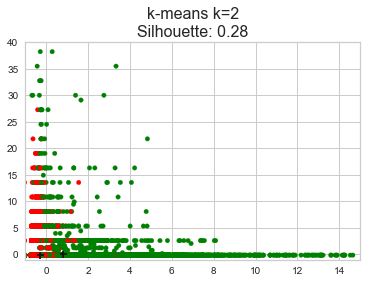

In [11]:
#On peut afficher les points et les centroïdes des 2 groupes)
colormap=np.array(['Red','green'])
plt.scatter(X_scaled[:,0],X_scaled[:,1],c=colormap[kmeans.labels_],s=20)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c="k",marker='+')
plt.title(f"k-means k=2\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 16}
)
plt.xlim(-1,15)
plt.ylim(-1,40)

In [12]:
labels = kmeans.labels_
print(labels[:100])

[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0]


### 1.1 Déterminer le nombre de clusters optimal 

#### 1.1.1 Méthode du coude

In [13]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

In [14]:
# liste Inertia pour stocker les valeurs pour chaque k
inertia = []
dict_kmeans = {}
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs,)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    dict_kmeans[k] = kmeans

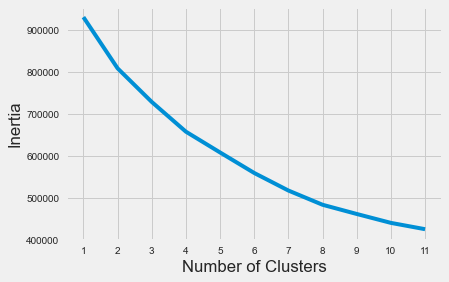

In [15]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 12), inertia)
plt.xticks(range(1, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

Il y a un point idéal où la courbe  commence à se plier, connue sous le nom de point de coude . La valeur x de ce point est considérée comme un compromis raisonnable entre l'erreur et le nombre de grappes. Ici il y a un point  légérement marqué à k=4 ,k=6 et k=8. La courbe se plie sans cassure marquée .
Je vais regarder le coefficient de silhouette.


#### 1.1.2 Coefficient de silhouette

est une mesure de la cohésion et de la séparation des clusters. Il quantifie à quel point un point de données s'intègre dans son cluster attribué en fonction de deux facteurs :

La proximité du point de données avec d'autres points du cluster La distance entre le point de données et les points d'autres clusters Les valeurs du coefficient de silhouette sont comprises entre -1et 1. Des nombres plus grands indiquent que les échantillons sont plus proches de leurs grappes qu'ils ne le sont des autres grappes.



In [16]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

#  Start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

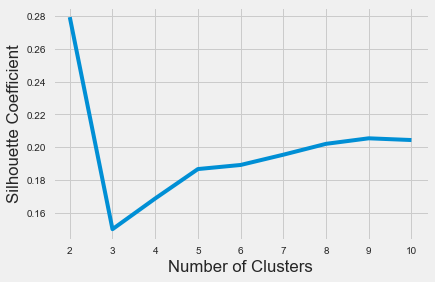

In [17]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

SSE est maximum pour k =9.
Je vais utiliser ElbowVisualizer et SilhouetteElbowVisualizer pour affiner le résultat

#### 1.1.3 ElbowVisualizer et SilhouetteElbowVisualizer

Il existe des outils dans sklearn qui permettent de calculer et d'afficher le meilleur k.

Je vais les utiliser au travers d'un Pipeline.

In [18]:
categorical_features = list(df.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
categorical_features

[]

In [19]:
numerical_features = list(df.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['total_freight_cost',
 'payment_sequential_nbre',
 'payment_installments_sum',
 'score',
 'traitement',
 'RFM_score',
 'recency',
 'frequency',
 'monetary_value',
 'harvesine_distance']

Je commence par recalibrer mes données numériques


In [20]:
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

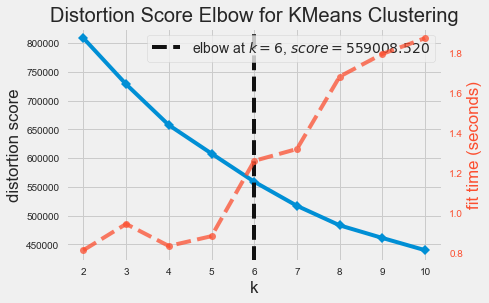

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(random_state=42,n_init=10),K=(4,12)))])
kmeans_visualizer.fit(df)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

 Le nombre de clusters est  ***k = 6***

On va vérifier avec  SilhouetteVisualizer

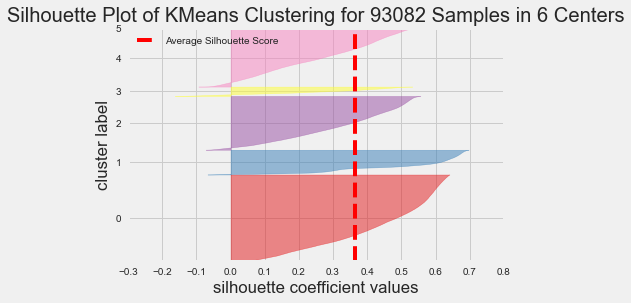

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93082 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
model_6clust = KMeans(n_clusters = 6, random_state=42,n_init=10)

sil_visualizer = SilhouetteVisualizer(model_6clust)
sil_visualizer.fit(df)    
sil_visualizer.show()  

Les 6 clusters ont un score de silhouette supérieur au score global.  
Les scores sont compris entre 0.5 et 0.7.  
Nous conservons k = 6 et nous  lançons une instance de kmeans 

#### 1.1.4.1 Kmeans avec le nombre de clusters k= 6 

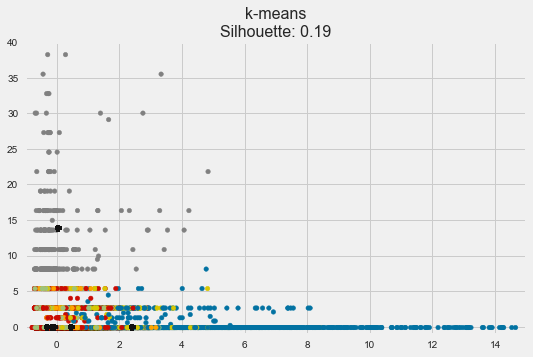

In [23]:
#  on lance le kmeans avec le nombre de clusters défini
kmeans = KMeans( n_clusters=6 ,n_init=10,random_state=42)
kmeans.fit(X_scaled)
labels_cls =kmeans.predict(X_scaled)
kmeans_silhouette = silhouette_score(
    X_scaled, kmeans.labels_
).round(2)
plt.figure(figsize=(8,5))
fte_colors = {0:'r',1: 'b',2:"g",3:"y",4:"orange",5:"grey",6:'c'  }
km_colors = [fte_colors[label] for label in kmeans.labels_]
# afficher les points des différents clusters
plt.scatter(X_scaled[:,0],X_scaled[:,1],c=km_colors,s=20)
# afficher les centroïdes
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c="k",marker='+')
plt.title(f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 16})
plt.xlim(-1,15)
plt.ylim(-1,40)
plt.show()

In [24]:
#Identification des  groupes obtenus
groupes_kmeans6 = labels_cls 
print('Numérotation de nos groupes : ' + str(np.unique(groupes_kmeans6)))

#Index trié des groupes
idg = np.argsort(groupes_kmeans6)

#Affichage des clients selon leurs groupes
df_kmeans6_choice = pd.DataFrame(df.index[idg], groupes_kmeans6[idg]).reset_index()
df_kmeans6_choice = df_kmeans6_choice.rename(columns={'index':'Groupe'})


Numérotation de nos groupes : [0 1 2 3 4 5]


In [25]:
df_kmeans6_choice.head()

,Groupe,customer_unique_id
0,0,0000366f3b9a7992bf8c76cfdf3221e2
1,0,56676df9045e84d31b95242cb0e9a344
2,0,566920f0be4bf6f70f23ad9b263c4b6c
3,0,566b65203cc956bb5511e06445ea41c4
4,0,b9985168e18b03feef0dcfa99e65fc4e


In [26]:
df_groupes_kmeans6 = pd.merge(df, df_kmeans6_choice, on='customer_unique_id')

In [27]:
df_groupes_kmeans6.head()

,customer_unique_id,total_freight_cost,payment_sequential_nbre,payment_installments_sum,score,traitement,RFM_score,recency,frequency,monetary_value,harvesine_distance,Groupe
0,0000366f3b9a7992bf8c76cfdf3221e2,12.00,1.0,8.0,5.0,6.411227,3.0,111,1,129.90,211.605022,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,8.29,1.0,1.0,4.0,3.285590,2.0,114,1,18.90,203.565543,2
2,0000f46a3911fa3c0805444483337064,17.22,1.0,8.0,3.0,25.731759,1.3,536,1,69.00,151.433717,2
3,0000f6ccb0745a6a4b88665a16c9f078,17.63,1.0,4.0,4.0,20.037083,1.3,320,1,25.99,1666.067959,3
4,0004aac84e0df4da2b147fca70cf8255,16.89,1.0,6.0,5.0,13.141134,2.7,287,1,180.00,175.432978,2


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93082 samples in 0.290s...
[t-SNE] Computed neighbors for 93082 samples in 27.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 93082
[t-SNE] Computed conditional probabilities for sample 2000 / 93082
[t-SNE] Computed conditional probabilities for sample 3000 / 93082
[t-SNE] Computed conditional probabilities for sample 4000 / 93082
[t-SNE] Computed conditional probabilities for sample 5000 / 93082
[t-SNE] Computed conditional probabilities for sample 6000 / 93082
[t-SNE] Computed conditional probabilities for sample 7000 / 93082
[t-SNE] Computed conditional probabilities for sample 8000 / 93082
[t-SNE] Computed conditional probabilities for sample 9000 / 93082
[t-SNE] Computed conditional probabilities for sample 10000 / 93082
[t-SNE] Computed conditional probabilities for sample 11000 / 93082
[t-SNE] Computed conditional probabilities for sample 12000 / 93082
[t-SNE] Computed conditional probabilities for sa

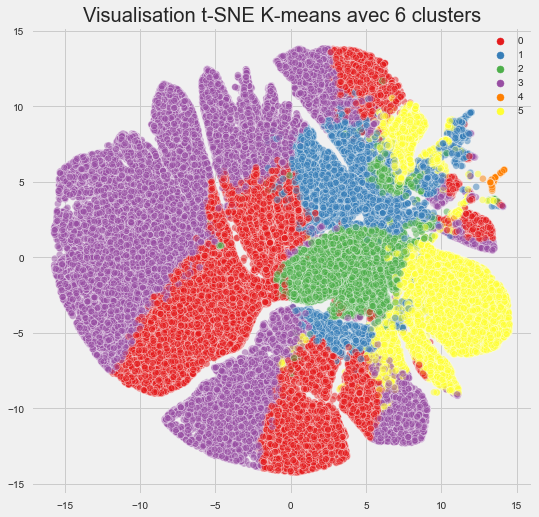

In [114]:
kmeans = KMeans( n_clusters=6 ,n_init=10,random_state=42)
kmeans.fit(X_scaled)


labels_cls =kmeans.predict(X_scaled)



tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=300,
                     n_jobs=-1,
                     init='pca',    
                     verbose=1
                    )

    # Application du T-SNE
df_km6 = tsne.fit_transform(X_scaled[:,:10])
plt.figure(figsize=(8,8))
plot = sns.scatterplot(
                x=df_km6[:,0], y=df_km6[:,1],
                hue=labels_cls,
                palette="Set1",
                data=df_groupes_kmeans6,
                legend="full",
                alpha=0.5).set(title = 'Visualisation t-SNE K-means avec 6 clusters')
    

In [28]:
df_groupes_kmeans6.groupby(['Groupe'])['customer_unique_id'].count()

Groupe
0    36212
1     5019
2    31133
3     9188
4    11276
5      254
Name: customer_unique_id, dtype: int64

In [29]:
#la comparaison des moyennes des groupes permet de dégager des tendances 
# afin d'identifier le(s) groupe(s)  le(s) plus porteur(s) à ce niveau de l'analyse
df_km6=df_groupes_kmeans6.groupby('Groupe').mean()
df_km6.reset_index()

,Groupe,total_freight_cost,payment_sequential_nbre,payment_installments_sum,score,traitement,RFM_score,recency,frequency,monetary_value,harvesine_distance
0,0,19.863947,1.025272,2.804719,4.654801,9.321732,3.456931,125.186623,1.122142,127.759660,319.065888
1,1,78.048836,1.033975,5.644925,3.873239,13.081874,4.075254,222.942618,2.619645,612.534864,476.210775
2,2,16.626502,1.032147,2.552763,4.582886,10.762490,2.260906,366.976970,1.046060,87.943920,331.447117
3,3,33.778078,1.037513,3.453472,4.125798,20.981891,2.963899,250.802133,1.073683,142.291460,1404.908372
4,4,21.828050,1.031438,2.959590,1.547904,20.792706,3.064269,230.861387,1.185882,124.580226,380.183120
5,5,24.816142,6.126312,6.424869,4.192913,12.946152,2.824803,274.925197,1.177165,127.768031,463.040358


 groupe 0 : Ces acheteurs ont effectué un achat très récemment(125 jrs).Le montant moyen total des achats est de 127 Reals.  Le temps de traitement moyen de 9.3 jrs est inférieur au temps moyen. (note moyenne de 4.6 ).Ils sont géographiquement très proches du HQ d'Olist (319 miles)  C'est un groupe très important (plus d'1/3 des clients) ***" Medium Value customer"Prévoir actions pour relancer ces clients  et déclencher nouveaux achats***
 
groupe 1 : Ces acheteurs ont effectué leur dernier achat il y a 223 jours.Le montant moyen total est de 612 Reals .le temps de traitement moyen de 13 jrs est proche du temps de traitement moyen.Ils sont géographiquement assez proches du HQ d'Olist (476 miles). Ils sont globalement  satisfaits (note moyenne de 3.87 ) ***"Top customers" clients réguliers avec panier important. Prévoir une relance avec offre promotionnelle sur articles/catégories les plus vendus à ces clients*** 

groupe 2 : Ces acheteurs ont effectué leur dernier achat il y a  367 jours.Le montant moyen total d est de 88 Reals. Le temps de traitement moyen de 11 jrs est inférieur au temps de traitement moyen.Ils sont géographiquement très proches du HQ d'Olist (331 miles). Ils sont globalement très satisfaits (note moyenne de 4.58 )C'est un groupe important (plus de 30000 clients) ***"Low customers" client occasionnels.Très satisfaits mais n'ont plus achetés depuis 1 an? Prévoir une relance avec offre promotionnelle -10% à durée limitée. L' achat pour un montant minimum au cours du trimestre déclenche la ristourne***  

groupe 3 : Ces acheteurs ont effectué leur dernier achat il y a  251 jours.Le montant moyen total  est de 143 Reals. Le temps de traitement moyen de 21 jrs est supérieur au temps de traitement moyen.Ils sont géographiquement très éloignés du HQ d'Olist (1405 miles). Ils sont globalement satisfaits (note moyenne de 4.12 ) C'est un groupe  important (plus de 9000 clients)  ***"High Value Customers" Clients réguliers Prévoir offre promotionnelle frais livraison réduite ou gratuite sur toute commande d'un montant minimum (à définir) passée dans les 2 mois

groupe 4 : Ces acheteurs ont effectué leur dernier achat il y a  231 jours.Le montant moyen total est de 124 Reals .le temps de traitement moyen de 21 jrs est supérieur au temps de traitement moyen.Ils sont géographiquement proches du HQ d'Olist (380 miles). Ils sont globalement très insatisfaits (note moyenne de 1.54) C'est un groupe important (plus de 11000 clients) ***"Lost ou nearly-lost customers" Prévoir action pour comprendre leur insatisfaction et relancer en proposant produit équivalent avec réduction et/ou meilleurs délais de livraison ***

groupe 5 : Ces acheteurs ont effectué leur dernier achat il y a  275 jours.Le montant moyen total est de 127 Reals. Le temps de traitement moyen de 13 jrs est proche du temps de traitement moyen.Ils sont géographiquement  assez proches du HQ d'Olist (380 miles). Ils sont globalement très satisfaits (note moyenne de 4.19) ***clients réguliers idem groupe 3 mais panier inférieur*** 


#### 1.1.4.2 Kmeans avec le nombre de clusters k =5

Au vu de la segmentation ci-dessous ,on peut regarder avec k = 5

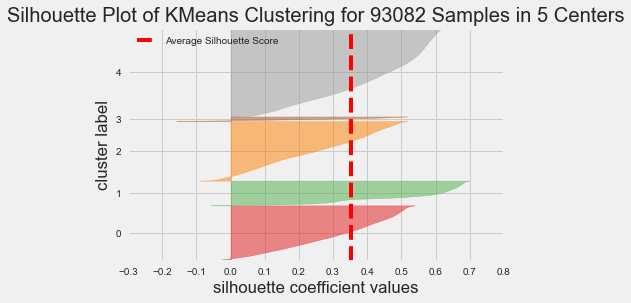

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93082 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
model_5clust = KMeans(n_clusters = 5, random_state=42,n_init=10)

sil_visualizer = SilhouetteVisualizer(model_5clust)
sil_visualizer.fit(df)    
sil_visualizer.show()  

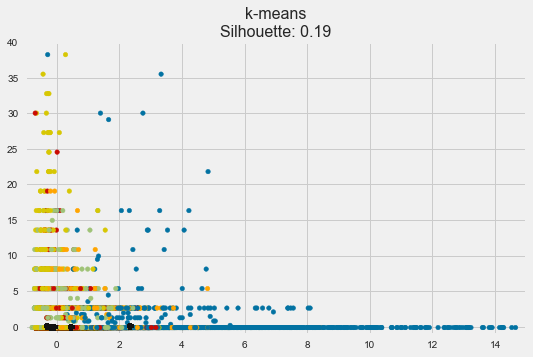

In [31]:
#  on lance le kmeans avec le nombre de clusters défini
kmeans = KMeans( n_clusters=5 ,n_init=10,random_state=42)
kmeans.fit(X_scaled)
labels_cls =kmeans.predict(X_scaled)
kmeans_silhouette = silhouette_score(
    X_scaled, kmeans.labels_
).round(2)
plt.figure(figsize=(8,5))
fte_colors = {0:'r',1: 'b',2:"g",3:"y",4:"orange",5:"grey",6:'c'  }
km_colors = [fte_colors[label] for label in kmeans.labels_]
# afficher les points des différents clusters
plt.scatter(X_scaled[:,0],X_scaled[:,1],c=km_colors,s=20)
# afficher les centroïdes
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c="k",marker='+')
plt.title(f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 16})
plt.xlim(-1,15)
plt.ylim(-1,40)
plt.show()

In [32]:
#Identification des  groupes obtenus
groupes_kmeans5 = labels_cls 
print('Numérotation de nos groupes : ' + str(np.unique(groupes_kmeans5)))

#Index trié des groupes
idg = np.argsort(groupes_kmeans5)

#Affichage des clients selon leurs groupes
df_kmeans5_choice = pd.DataFrame(df.index[idg], groupes_kmeans5[idg]).reset_index()
df_kmeans5_choice = df_kmeans5_choice.rename(columns={'index':'Groupe'})


Numérotation de nos groupes : [0 1 2 3 4]


In [33]:
df_groupes_kmeans5 = pd.merge(df, df_kmeans5_choice, on='customer_unique_id')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93082 samples in 0.280s...
[t-SNE] Computed neighbors for 93082 samples in 5.551s...
[t-SNE] Computed conditional probabilities for sample 1000 / 93082
[t-SNE] Computed conditional probabilities for sample 2000 / 93082
[t-SNE] Computed conditional probabilities for sample 3000 / 93082
[t-SNE] Computed conditional probabilities for sample 4000 / 93082
[t-SNE] Computed conditional probabilities for sample 5000 / 93082
[t-SNE] Computed conditional probabilities for sample 6000 / 93082
[t-SNE] Computed conditional probabilities for sample 7000 / 93082
[t-SNE] Computed conditional probabilities for sample 8000 / 93082
[t-SNE] Computed conditional probabilities for sample 9000 / 93082
[t-SNE] Computed conditional probabilities for sample 10000 / 93082
[t-SNE] Computed conditional probabilities for sample 11000 / 93082
[t-SNE] Computed conditional probabilities for sample 12000 / 93082
[t-SNE] Computed conditional probabilities for sam

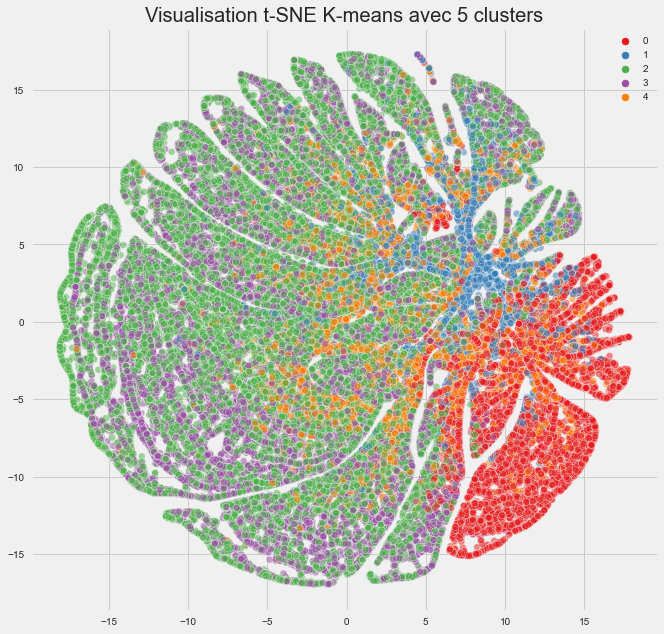

In [34]:
kmeans = KMeans( n_clusters=5 ,n_init=10,random_state=42)
kmeans.fit(X_scaled)


labels_cls =kmeans.predict(X_scaled)



tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=300,
                     n_jobs=-1,
                     init='pca',    
                     verbose=1
                    )

    # Application du T-SNE
df5_km5 = tsne.fit_transform(X_scaled[:,:5])
plt.figure(figsize=(10,10))
plot = sns.scatterplot(
                x=df5_km5[:,0], y=df5_km5[:,1],
                hue=labels_cls,
                palette="Set1",
                data=df_groupes_kmeans5,
                legend="full",
                alpha=0.5).set(title = 'Visualisation t-SNE K-means avec 5 clusters')
    

In [35]:
df_groupes_kmeans5.groupby(['Groupe'])['customer_unique_id'].count()

Groupe
0    11287
1     5233
2    36304
3    31064
4     9194
Name: customer_unique_id, dtype: int64

In [36]:
#la comparaison des moyennes des groupes permet de dégager des tendances 
# afin d'identifier le(s) groupe(s)  le(s) plus porteur(s) à ce niveau de l'analyse
df_km5=df_groupes_kmeans5.groupby('Groupe').mean()
df_km5.reset_index()

,Groupe,total_freight_cost,payment_sequential_nbre,payment_installments_sum,score,traitement,RFM_score,recency,frequency,monetary_value,harvesine_distance
0,0,21.759697,1.040533,2.957060,1.548433,20.785350,3.061407,230.939577,1.184283,124.016818,379.783041
1,1,76.880371,1.070311,5.711439,3.890207,13.044719,4.073935,222.815784,2.583986,602.685104,473.922560
2,2,19.746957,1.030130,2.778009,4.655561,9.320704,3.449675,125.178603,1.119298,126.375058,318.955858
3,3,16.638372,1.054978,2.584621,4.582475,10.767613,2.259249,368.012040,1.046066,88.111161,331.767765
4,4,33.695677,1.050105,3.447955,4.122834,21.000908,2.962378,250.780400,1.073200,141.903717,1405.684021


 **groupe 0 :  " Medium Value customer" envoyer folder offre promotionnelle jusqu'à 20% sur série articles de saison**
 
**groupe 1 : "Top customers" clients réguliers avec panier important. Prévoir une relance avec offre promotionnelle sur articles/catégories les plus vendus à ces clients***

**groupe 2 : "Low customers" client occasionnels.Très satisfaits mais n'ont plus achetés depuis 1 an? Prévoir une relance avec offre promotionnelle -10% à durée limitée. L' achat pour un montant minimum au cours du trimestre déclenche la ristourne** 

**groupe 3 : **"High Value Customers" Clients réguliers Prévoir offre promotionnelle frais livraison réduite ou gratuite sur toute commande d'un montant minimum (à définir) passée dans les 2 mois**

**groupe 4 :  "Lost ou nearly-lost customers" Prévoir action pour comprendre leur insatisfaction et relancer en proposant produit équivalent avec réduction et/ou meilleurs délais de livraison**



#### 1.1.4.3 Kmeans avec 4 variables numériques

Je vais conserver uniquement recency, fréquency , monetary_value et le score (note attribuée par les client)

In [37]:
df_4v=data[['customer_unique_id','recency','frequency','monetary_value','score']]

In [38]:
#Transformation en array Numpy
df_4v.set_index('customer_unique_id', inplace=True)
X = df_4v.values
X.shape

(93082, 4)

In [39]:
numerical_features = list(df_4v.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['recency', 'frequency', 'monetary_value', 'score']

In [40]:
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

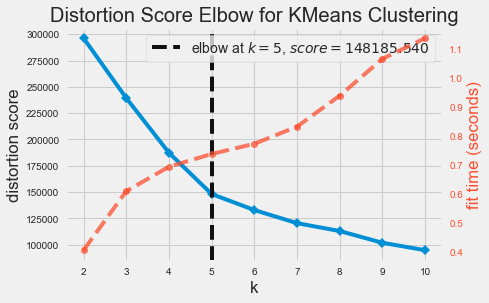

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(random_state=42,n_init=10),K=(4,12)))])
kmeans_visualizer.fit(df_4v)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

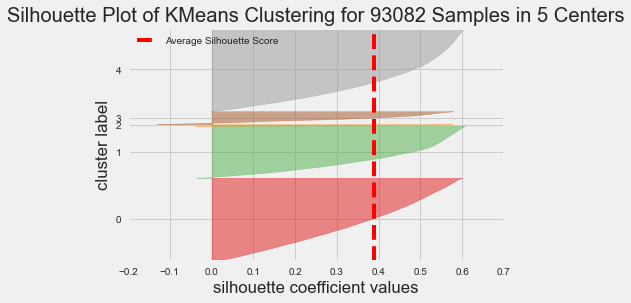

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93082 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [42]:
model_4v = KMeans(n_clusters = 5, random_state=42,n_init=10)

sil_visualizer = SilhouetteVisualizer(model_4v)
sil_visualizer.fit(df_4v)    
sil_visualizer.show()  

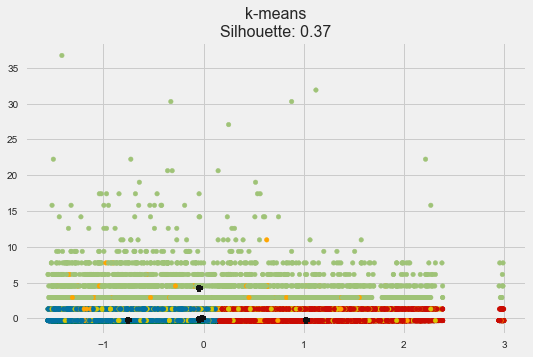

In [91]:
#  on lance le kmeans avec le nombre de clusters défini
kmeans = KMeans( n_clusters=5 ,n_init=10,random_state=42)
kmeans.fit(X_scaled)
labels_cls =kmeans.predict(X_scaled)
kmeans_silhouette = silhouette_score(
    X_scaled, kmeans.labels_
).round(2)
plt.figure(figsize=(8,5))
fte_colors = {0:'r',1: 'b',2:"g",3:"y",4:"orange",5:"grey",6:'c'  }
km_colors = [fte_colors[label] for label in kmeans.labels_]
# afficher les points des différents clusters
plt.scatter(X_scaled[:,0],X_scaled[:,1],c=km_colors,s=20)
# afficher les centroïdes
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c="k",marker='+')
plt.title(f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 16})
#plt.xlim(-1,15)
#plt.ylim(-1,40)
plt.show()

On va regarder pour une meilleure visualisation avec T-sne

In [93]:
#Identification des  groupes obtenus
groupes_kmeans_4v = labels_cls 
print('Numérotation de nos groupes : ' + str(np.unique(groupes_kmeans_4v)))

#Index trié des groupes
idg = np.argsort(groupes_kmeans_4v)

#Affichage des clients selon leurs groupes
df_kmeans_4v_choice = pd.DataFrame(df_4v.index[idg], groupes_kmeans_4v[idg]).reset_index()
df_kmeans_4v_choice = df_kmeans_4v_choice.rename(columns={'index':'Groupe'})

# jointure 
df_groupes_kmeans_4v = pd.merge(df_4v, df_kmeans_4v_choice, on='customer_unique_id')


Numérotation de nos groupes : [0 1 2 3 4]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93082 samples in 0.163s...
[t-SNE] Computed neighbors for 93082 samples in 2.759s...
[t-SNE] Computed conditional probabilities for sample 1000 / 93082
[t-SNE] Computed conditional probabilities for sample 2000 / 93082
[t-SNE] Computed conditional probabilities for sample 3000 / 93082
[t-SNE] Computed conditional probabilities for sample 4000 / 93082
[t-SNE] Computed conditional probabilities for sample 5000 / 93082
[t-SNE] Computed conditional probabilities for sample 6000 / 93082
[t-SNE] Computed conditional probabilities for sample 7000 / 93082
[t-SNE] Computed conditional probabilities for sample 8000 / 93082
[t-SNE] Computed conditional probabilities for sample 9000 / 93082
[t-SNE] Computed conditional probabilities for sample 10000 / 93082
[t-SNE] Computed conditional probabilities for sample 11000 / 93082
[t-SNE] Computed conditional probabilities for sample 12000 / 93082
[t-SNE] Computed conditional probabilities for sam

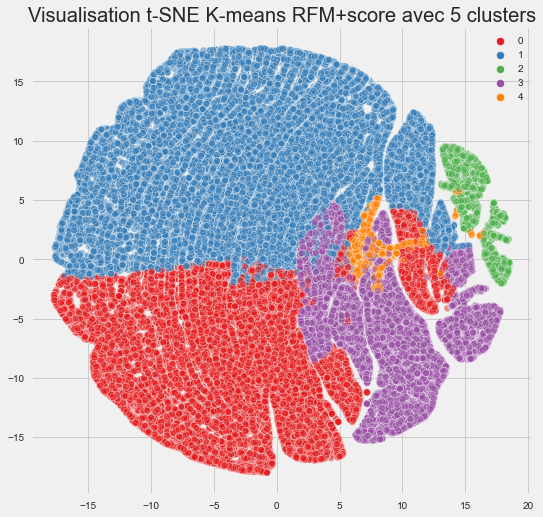

In [95]:

labels_cls =kmeans.predict(X_scaled)

tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=300,
                     n_jobs=-1,
                     init='pca',    
                     verbose=1
                    )

    # Application du T-SNE
df4V_pro = tsne.fit_transform(X_scaled[:,:5])
plt.figure(figsize=(8,8))
plot = sns.scatterplot(
                x=df4V_pro[:,0], y=df4V_pro[:,1],
                hue=labels_cls,
                palette="Set1",
                data=model_4v,
                legend="full",
                alpha=0.5).set(title = 'Visualisation t-SNE K-means RFM+score avec 5 clusters')
    

In [46]:
# afficher le nombre d'individus par groupe
df_groupes_kmeans_4v.groupby(['Groupe'])['customer_unique_id'].count()

Groupe
0    11287
1     5233
2    36304
3    31064
4     9194
Name: customer_unique_id, dtype: int64

In [47]:
#la comparaison des moyennes des groupes permet de dégager des tendances 
# afin d'identifier le(s) groupe(s)  le(s) plus porteur(s) à ce niveau de l'analyse
df_km_4v=df_groupes_kmeans_4v.groupby('Groupe').mean()
df_km_4v.reset_index()

,Groupe,recency,frequency,monetary_value,score
0,0,230.939577,1.184283,124.016818,1.548433
1,1,222.815784,2.583986,602.685104,3.890207
2,2,125.178603,1.119298,126.375058,4.655561
3,3,368.012040,1.046066,88.111161,4.582475
4,4,250.780400,1.073200,141.903717,4.122834


 **groupe 0 :  "Low customers" client occasionnels.Très satisfaits mais n'ont plus achetés depuis 1 an? Prévoir une relance avec offre promotionnelle -10% à durée limitée. L'achat pour un montant minimum au cours du trimestre déclenche la ristourne** 
  
**groupe 1 : " Medium Value customer" envoyer folder offre promotionnelle jusqu'à 20% sur série articles de saison**

**groupe 2 : "High Value Customers" Clients réguliers Prévoir offre promotionnelle avec frais livraison réduite ou gratuite sur toute commande d'un montant minimum (à définir) passée dans les 2 mois**

**groupe 3 : "Lost ou nearly-lost customers" Prévoir action pour comprendre leur insatisfaction et relancer en proposant produit équivalent avec réduction et/ou meilleurs délais de livraison**

**groupe 4 : "Top customers" clients réguliers avec panier important. Prévoir une relance avec offre promotionnelle sur articles/catégories les plus vendus à ces clients**


## 2. Application de l'algorithme DBSCAN (Density-based spatial clustering of applications with noise

Contrairement au clustering k-means, DBSCAN ne nécessite pas de spécifier initialement le nombre de clusters. Cependant, DBSCAN nécessite deux paramètres, à savoir. le rayon des voisinages pour un point de données donné p ( ε) et le nombre minimum de points de données dans un ε-voisinage donné pour former des grappes ( minPts).
Après plusieurs essais en faisant varier ε et le nombre minimal de points , 2 valeurs  

pour réduire le temps de calcul je travaille sur un sampling de 10000 échantillons

In [48]:
df_sampling = df.sample(n=10000, random_state = 42).reset_index()


In [49]:
#Transformation en array Numpy
df_sampling.set_index('customer_unique_id', inplace=True)
X = df_sampling.values
X.shape

(10000, 10)

In [50]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [51]:
epsilon = 1
min_samples=3
# Compute DBSCAN
db = DBSCAN( eps=epsilon, min_samples=min_samples)
db.fit(X_scaled)
labels = db.labels_
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 47
Estimated no. of noise points: 1733


On peut déterminer le epsilon qui nous donne une clustérisation acceptable(k compris entre 4 et 8)pour  une segmentation clients et un nombre réduit de points "outliers" . 

In [52]:
range_eps=np.arange(1.5,3.0, 0.10)
for n in range_eps:
    print('eps value is '+str(round(n,1)))
    db=DBSCAN(eps=n,min_samples=3).fit(X_scaled)
    labels=db.labels_
    no_clusters = len(np.unique(labels) )
    no_noise = np.sum(np.array(labels) == -1, axis=0)
    core_samples_mask=np.zeros_like(db.labels_,dtype=bool)
    core_samples_mask[db.core_sample_indices_]=True
    print(set(labels))
    silhouette_avg=silhouette_score(X_scaled,labels)
    print("For eps value ="+str(round(n,1)),
         ' the average silhouette score is :',round(silhouette_avg,2))
    print('Estimated no. of clusters: %d' % no_clusters,'  ','Estimated no. of noise points: %d' % no_noise)
    print('  ')
    

eps value is 1.5
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, -1}
For eps value =1.5  the average silhouette score is : -0.03
Estimated no. of clusters: 31    Estimated no. of noise points: 602
  
eps value is 1.6
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1}
For eps value =1.6  the average silhouette score is : 0.03
Estimated no. of clusters: 23    Estimated no. of noise points: 510
  
eps value is 1.7
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -1}
For eps value =1.7  the average silhouette score is : 0.11
Estimated no. of clusters: 19    Estimated no. of noise points: 452
  
eps value is 1.8
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
For eps value =1.8  the average silhouette score is : 0.18
Estimated no. of clusters: 16    Estimated no. of noise points: 383
  
eps value is 1.9
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
For eps value =1.9  the average silhoue

Un eps de 2.7 et un min_samples =3 nous donne un silhouette score moyen de 0.56  avec 5 clusters et 143 outliers.  
Nous allons faire varier le nombre de min_samples 

In [53]:
range_min_samples=np.arange(1,11,1)
for n in range_min_samples:
    print('min_samples value is '+str(round(n,1)))
    db=DBSCAN(eps=2.7,min_samples=n).fit(X_scaled)
    labels=db.labels_
    silhouette_avg=silhouette_score(X_scaled,labels)
    no_clusters = len(np.unique(labels) )
    no_noise = np.sum(np.array(labels) == -1, axis=0)
    core_samples_mask=np.zeros_like(db.labels_,dtype=bool)
    core_samples_mask[db.core_sample_indices_]=True
    #print(set(labels))
    
    print("For min_samples value ="+str(round(n,1)),"  "
          'estimated no. of clusters: %d' % no_clusters,'  ',
          'estimated no. of noise points: %d' % no_noise)
    print('The average silhouette score is :',round(silhouette_avg,2))
    print('  ')

min_samples value is 1
For min_samples value =1   estimated no. of clusters: 99    estimated no. of noise points: 0
The average silhouette score is : 0.23
  
min_samples value is 2
For min_samples value =2   estimated no. of clusters: 11    estimated no. of noise points: 89
The average silhouette score is : 0.55
  
min_samples value is 3
For min_samples value =3   estimated no. of clusters: 6    estimated no. of noise points: 99
The average silhouette score is : 0.56
  
min_samples value is 4
For min_samples value =4   estimated no. of clusters: 4    estimated no. of noise points: 108
The average silhouette score is : 0.59
  
min_samples value is 5
For min_samples value =5   estimated no. of clusters: 5    estimated no. of noise points: 112
The average silhouette score is : 0.59
  
min_samples value is 6
For min_samples value =6   estimated no. of clusters: 2    estimated no. of noise points: 132
The average silhouette score is : 0.68
  
min_samples value is 7
For min_samples value =7 

Pour un eps = 2.7:    

la valeur de min_samples = 3 donne un silhouette score = 0.56 avec 5 clusters et 99 outliers

Je conserve min_samples = 3 pour la suite

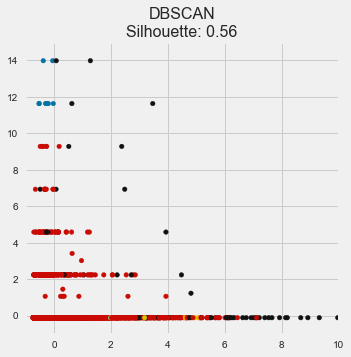

In [54]:
#  on lance le dbscan avec les valeurs eps et min_samples définies
db = DBSCAN(eps=2.7, min_samples=3)
predictions = db.fit_predict(X_scaled)
#labels_cls =db.predict(X_scaled)
dbscan_silhouette = silhouette_score(
    X_scaled, db.labels_
).round(2)
plt.figure(figsize=(5,5))
fte_colors = {0:'r',1: 'b',2:"g",3:"y",4:"orange",5:"c",6:'grey',-1:'k'  }
km_colors = [fte_colors[label] for label in db.labels_]
# afficher les points des différents clusters
plt.scatter(X_scaled[:,0],X_scaled[:,1],c=km_colors,s=20,label=km_colors)
# ajuster échelle des axes
plt.xlim(-1,10)
plt.ylim(-1,15)
plt.title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 16})

plt.show()

In [55]:
#Identification des  groupes obtenus
groupes_dbscan = db.labels_ 
print('Numérotation de nos groupes : ' + str(np.unique(groupes_dbscan)))

#Index trié des groupes
idg = np.argsort(groupes_dbscan)

#Affichage des clients selon leurs groupes
df_dbscan_choice = pd.DataFrame(df_sampling.index[idg], groupes_dbscan[idg]).reset_index()
df_dbscan_choice = df_dbscan_choice.rename(columns={'index':'Groupe'})


Numérotation de nos groupes : [-1  0  1  2  3  4]


In [56]:
df_dbscan_choice.head()

,Groupe,customer_unique_id
0,-1,4bf5e216e3bcd7c0edd5463ec30bd552
1,-1,a4d4a76b47ccec27db5ea63da11debf5
2,-1,5d0592e49136297ece57979183c9cac2
3,-1,14f5335a43420b92aa77e1f35ada3f42
4,-1,c143eafe10719dcc7dc0a855b2e3554d


In [57]:
df_groupes_dbscan = pd.merge(df, df_dbscan_choice, on='customer_unique_id')

In [58]:
df_gr=df_groupes_dbscan.groupby(['Groupe'])['customer_unique_id'].count()
df_gr

Groupe
-1      99
 0    9880
 1       9
 2       6
 3       3
 4       3
Name: customer_unique_id, dtype: int64

In [59]:
#la comparaison des moyennes des groupes permet de dégager des tendances afin d'identifier le(s) groupe(s)  le(s) plus porteur(s) à ce niveau de l'analyse
df_db=df_groupes_dbscan.groupby('Groupe').mean()
df_db=pd.merge(df_gr,df_db,on='Groupe',how='inner')
df_db

,customer_unique_id,total_freight_cost,payment_sequential_nbre,payment_installments_sum,score,traitement,RFM_score,recency,frequency,monetary_value,harvesine_distance
Groupe,,,,,,,,,,,
-1,99,120.349091,2.167388,6.529582,3.132107,28.107441,3.763636,235.797980,3.202020,906.550404,750.524586
0,9880,22.903856,1.034008,2.939718,4.153682,12.444375,2.977733,236.903138,1.167409,133.963367,449.889191
1,9,15.551111,6.222222,6.222222,2.888889,10.717576,3.000000,241.333333,1.111111,80.773333,461.205525
2,6,38.746667,1.000000,9.333333,1.000000,23.116051,3.500000,219.666667,1.166667,1839.400000,224.165932
3,3,110.803333,1.000000,1.400000,1.866667,25.407613,4.900000,103.000000,5.333333,637.133333,1123.529761
4,3,129.200000,1.000000,2.333333,4.185185,15.413513,4.233333,224.000000,8.666667,555.433333,239.469690


la clustérisation avec DBSCAN donne des groupes très disproportionnés en terme de population qui s'imbriquent les uns dans les autres et ne sont pas exploitables dans notre cas.

## 3.  ACP 

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93082 entries, 0 to 93081
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93082 non-null  object 
 1   total_freight_cost        93082 non-null  float64
 2   payment_sequential_nbre   93082 non-null  float64
 3   payment_installments_sum  93082 non-null  float64
 4   score                     93082 non-null  float64
 5   traitement                93082 non-null  float64
 6   RFM_score                 93082 non-null  float64
 7   recency                   93082 non-null  int64  
 8   frequency                 93082 non-null  int64  
 9   monetary_value            93082 non-null  float64
 10  harvesine_distance        93082 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 7.8+ MB


#### 3.1  Préparation des données et calcul de l'ACP

In [61]:
acp_in=data.copy()
# suppression des colonnes non numériques
X=acp_in.select_dtypes(np.number)
#Je vais standardiser() centrer et réduire) mes données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
pca = PCA()
pca.fit(X_scaled)

PCA()

#### 3.2 Calcul de la variance expliquée

In [62]:
print(pca.explained_variance_)

[2.32138865 1.59962889 1.20930595 1.05797518 0.99265388 0.91935816
 0.6544095  0.54172224 0.41328272 0.29038228]


In [63]:
resume_var = pd.DataFrame(
    {
        "Dimension" : ["dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100,1),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100,1)
    }
)
resume_var

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,dim1,2.321389,23.2,23.2
1,dim2,1.599629,16.0,39.2
2,dim3,1.209306,12.1,51.3
3,dim4,1.057975,10.6,61.9
4,dim5,0.992654,9.9,71.8
5,dim6,0.919358,9.2,81.0
6,dim7,0.654409,6.5,87.5
7,dim8,0.541722,5.4,93.0
8,dim9,0.413283,4.1,97.1
9,dim10,0.290382,2.9,100.0


#### 3.3 Eboulis des valeurs propres

In [64]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

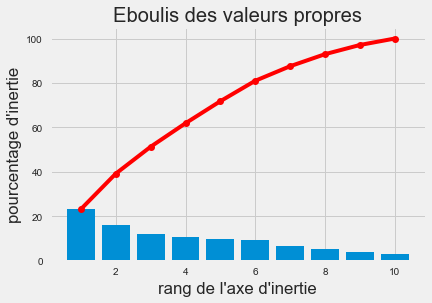

In [65]:
display_scree_plot(pca)

6 variables suffisent à expliquer 81% de la variance  


#### 3.4 Représentation des individus

In [66]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(8,8))
        
            # affichage des points
            if illustrative_var is None:
                 plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=0.4,s=2)
                    
                    
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=0.8,s=2, label=value)
                plt.legend()

            
                
                
            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1
            plt.xlim([-boundary*.15,boundary*.3])
            plt.ylim([-boundary*.5,boundary*.5])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

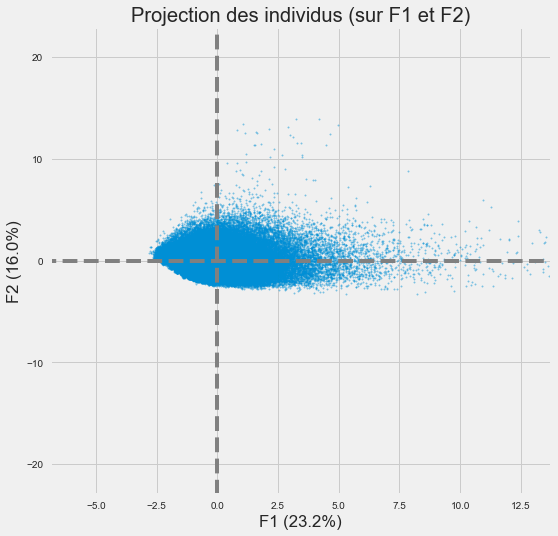

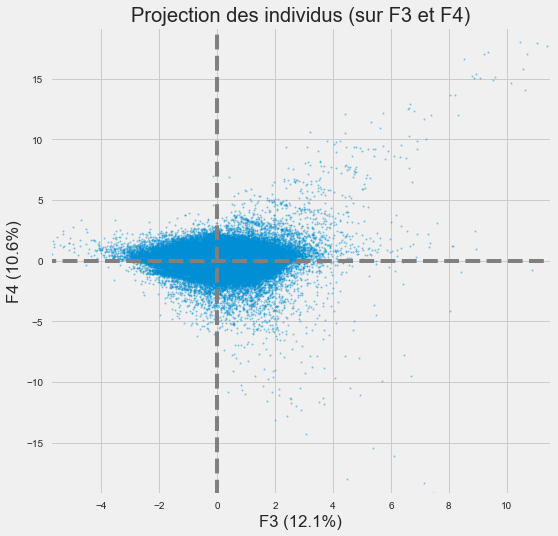

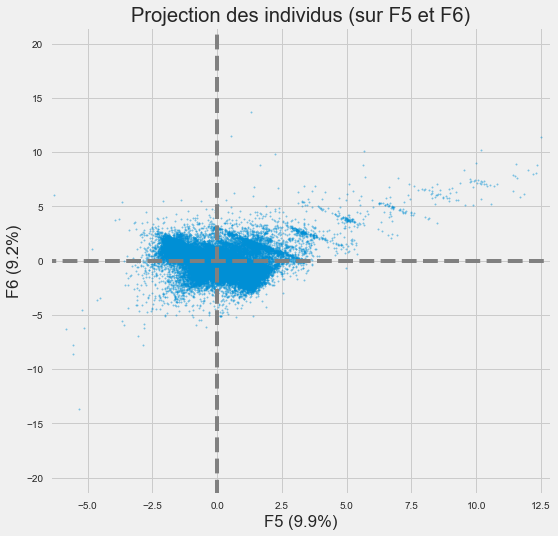

In [67]:
n_comp=6
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = None,illustrative_var=None)

plt.show()

In [68]:
df_pca = pca.transform(X_scaled)

nous allons créer un DataFrame en ne prenant que les six premières dimensions, ainsi que customer_unique_id.

In [69]:
# Transformation en DataFrame pandas
df_pca_6pc = pd.DataFrame({
    "customer" : acp_in["customer_unique_id"],
    "PC1" : df_pca[:,0], 
    "PC2" : df_pca[:,1],
    "PC3" : df_pca[:,2],
    "PC4" : df_pca[:,3],
    "PC5" : df_pca[:,4],
    "PC6" : df_pca[:,5],
})

# Résultat (premières lignes)
df_pca_6pc.head()

,customer,PC1,PC2,PC3,PC4,PC5,PC6
0,0000366f3b9a7992bf8c76cfdf3221e2,0.003861,-1.124365,0.740857,1.121117,-0.296186,-0.934241
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-1.531228,-0.864112,-0.377341,-0.272143,0.318446,-0.023023
2,0000f46a3911fa3c0805444483337064,-0.961351,2.489900,1.444263,-0.176022,0.772966,-1.722030
3,0000f6ccb0745a6a4b88665a16c9f078,-0.725742,2.890198,-0.144968,0.572598,-1.430686,1.103984
4,0004aac84e0df4da2b147fca70cf8255,-0.290790,-0.150378,1.042276,0.394231,-0.219371,-0.772751


#### 3.5 Représentation des variables

In [70]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 2premiers plans factoriels, donc les 4 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        

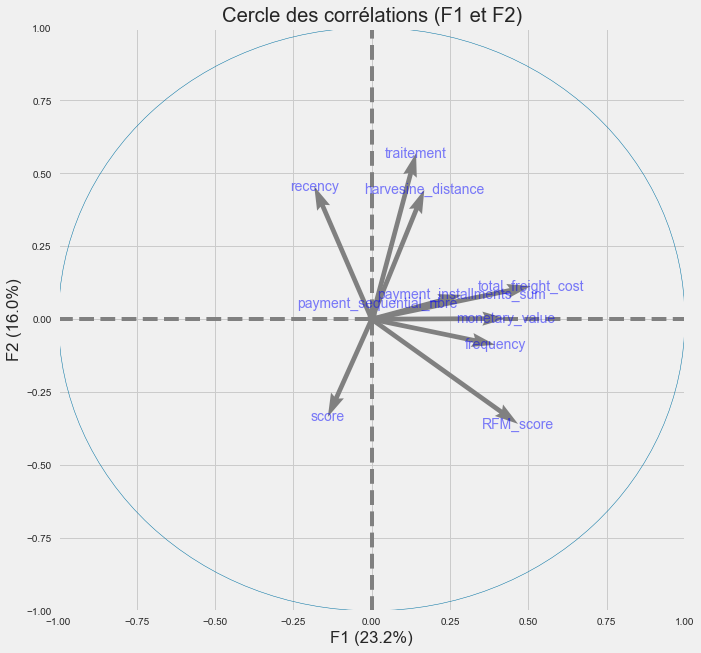

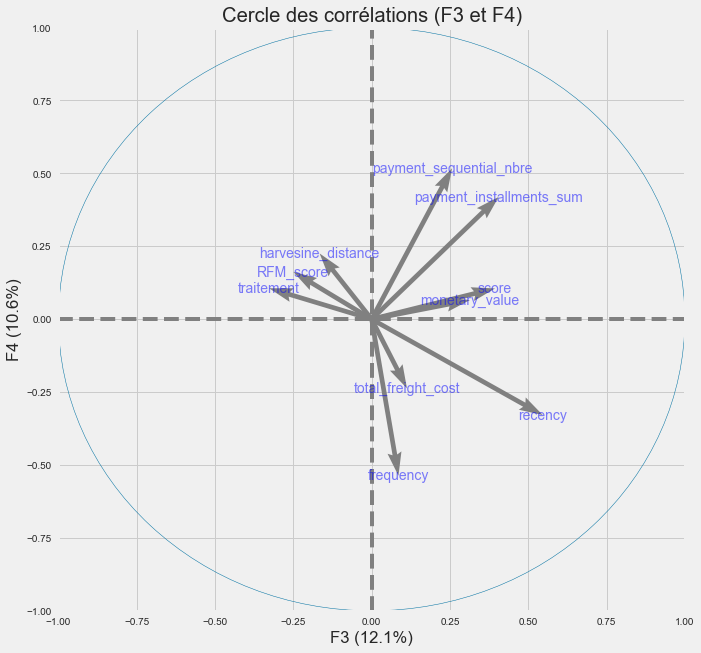

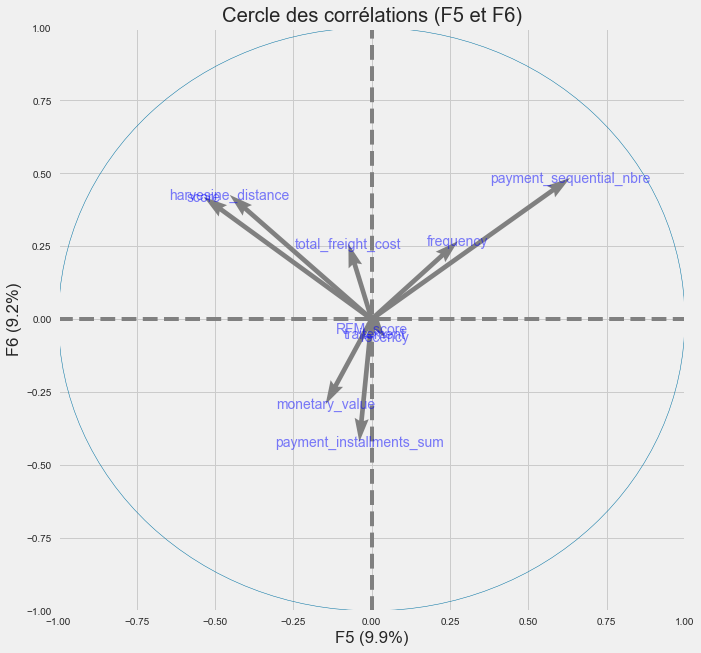

In [71]:
# Cercle des corrélations
n_comp=6
pca=pca
features = X.columns
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))


On peut regarder le poids de chaque variable dans les composantes principales  
Pour cela on crée un dataframe 

In [72]:
weight_pc = pd.DataFrame(pca.components_,columns = acp_in.columns[1:],
                         index=["PC1","PC2","PC3","PC4","PC5","PC6",
                                "PC7","PC8","PC9","PC10"])
weight_pc.index.name="Composante Principale"
weight_pc    

,total_freight_cost,payment_sequential_nbre,payment_installments_sum,score,traitement,RFM_score,recency,frequency,monetary_value,harvesine_distance
Composante Principale,,,,,,,,,,
PC1,0.507966,0.017265,0.287752,-0.139876,0.141777,0.467448,-0.183205,0.394086,0.428416,0.168194
PC2,0.113495,0.053120,0.083576,-0.335021,0.569166,-0.359031,0.455483,-0.087654,0.002285,0.443923
PC3,0.112739,0.256790,0.405579,0.394023,-0.327480,-0.250166,0.546283,0.085595,0.313674,-0.166224
PC4,-0.237136,0.517518,0.419266,0.105515,0.106120,0.162324,-0.328703,-0.536834,0.065629,0.225545
PC5,-0.074173,0.633524,-0.039234,-0.535580,0.009327,0.000251,0.041928,0.275424,-0.146924,-0.453288
PC6,0.258440,0.484430,-0.420749,0.419049,-0.050716,-0.035233,-0.062347,0.267555,-0.291425,0.426252
PC7,0.081267,0.162312,-0.597682,0.041335,0.152332,-0.030337,0.007372,-0.320153,0.667185,-0.190540
PC8,-0.047931,-0.013480,0.093367,0.484467,0.711447,0.101978,0.001569,0.143239,-0.152093,-0.440325
PC9,0.727274,-0.021220,0.112894,-0.042586,-0.033465,-0.356372,-0.270188,-0.354359,-0.233423,-0.273650


on voit que la composante principale 1 est fortement influencée par le coût du transport et le RFM_score.  
Si on regarde les corrélations . Elles sont significatives pour ces variables. Je vais les supprimer et refaire l'analyse 

In [73]:
def correlation_matrice(df):

    mask=np.triu(np.ones_like(df.corr(),dtype=bool))
    sns.heatmap(df.corr(),mask=mask,center=0,cmap='RdBu',linewidths=1,annot=True,fmt='.2f',vmin=-1,vmax=1)
    plt.title('Carte des corrélations',fontsize=15,fontweight="bold")
    plt.show()

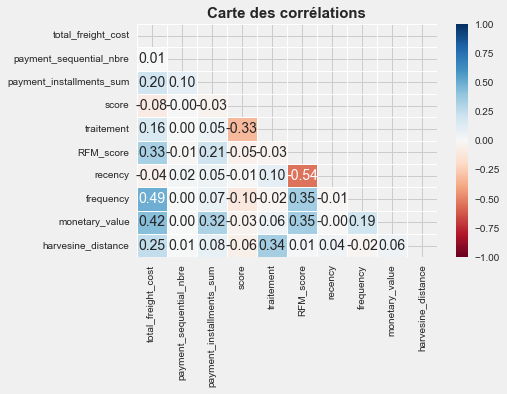

In [74]:
correlation_matrice(acp_in)

## 4.  ACP  après suppression des variables corrélées

#### 4.1  Préparation des données ert calcul de l'ACP

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93082 entries, 0 to 93081
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93082 non-null  object 
 1   total_freight_cost        93082 non-null  float64
 2   payment_sequential_nbre   93082 non-null  float64
 3   payment_installments_sum  93082 non-null  float64
 4   score                     93082 non-null  float64
 5   traitement                93082 non-null  float64
 6   RFM_score                 93082 non-null  float64
 7   recency                   93082 non-null  int64  
 8   frequency                 93082 non-null  int64  
 9   monetary_value            93082 non-null  float64
 10  harvesine_distance        93082 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 7.8+ MB


In [105]:
# je supprime les 2 variables corrélées
acp_in2=data.drop(columns=['RFM_score','total_freight_cost']).copy()
X=acp_in2.select_dtypes(np.number)

In [106]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [107]:
pca2 = PCA()
pca2.fit(X_scaled)

PCA()

#### 4.2 Calcul de la variance expliquée

In [108]:
resume_var = pd.DataFrame(
    {
        "Dimension" : ["dim" + str(x + 1) for x in range(len(pca2.explained_variance_))], 
        "Variance expliquée" : pca2.explained_variance_,
        "% variance expliquée" : np.round(pca2.explained_variance_ratio_ * 100,1),
        "% cum. var. expliquée" : np.round(np.cumsum(pca2.explained_variance_ratio_) * 100,1)
    }
)
resume_var

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,dim1,1.610105,20.1,20.1
1,dim2,1.326582,16.6,36.7
2,dim3,1.082342,13.5,50.2
3,dim4,0.987709,12.3,62.6
4,dim5,0.966307,12.1,74.7
5,dim6,0.839096,10.5,85.2
6,dim7,0.650727,8.1,93.3
7,dim8,0.537217,6.7,100.0


6 composantes principales expliquent 85 % de la variance des données

#### 4.3 Eboulis des valeurs propres

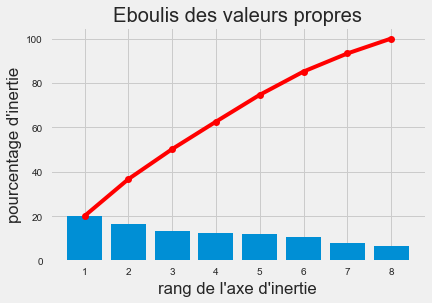

In [109]:
display_scree_plot(pca2)

#### 4.4 Représentation des individus

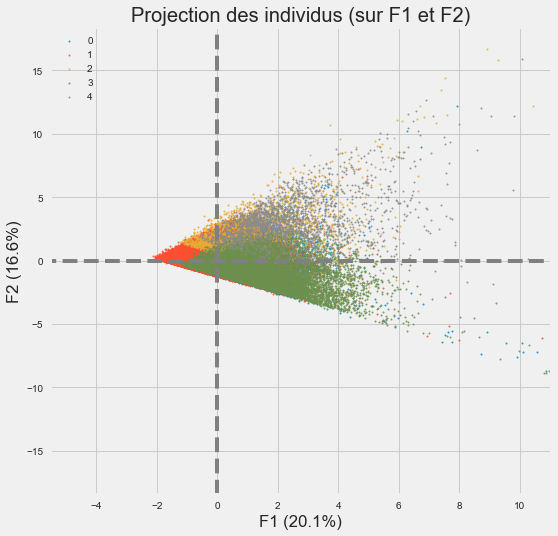

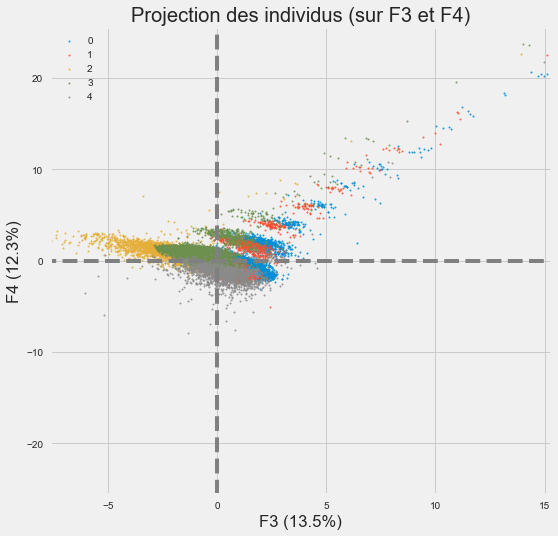

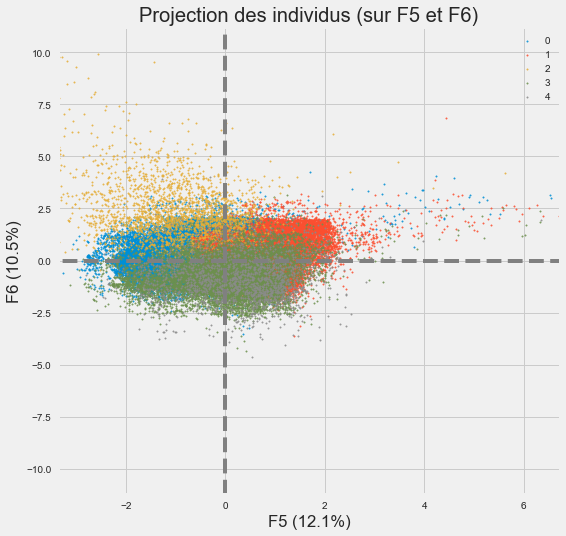

In [111]:
n_comp=6
X_projected = pca2.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca2, [(0,1),(2,3),(4,5)], labels = None,illustrative_var=df_groupes_kmeans_4v['Groupe'])

plt.show()

In [82]:
df_pca2 = pca2.transform(X_scaled)

In [83]:
# Transformation en DataFrame pandas
df_pca2_6pc = pd.DataFrame({
    "customer" : acp_in2["customer_unique_id"],
    "PC1" : df_pca2[:,0], 
    "PC2" : df_pca2[:,1],
    "PC3" : df_pca2[:,2],
    "PC4" : df_pca2[:,3],
    "PC5" : df_pca2[:,4],
    "PC6" : df_pca2[:,5],
})

# Résultat (premières lignes)
df_pca2_6pc.head()

,customer,PC1,PC2,PC3,PC4,PC5,PC6
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.428061,1.390278,0.466402,-0.462343,0.746422,-0.912070
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-1.427173,-0.159707,-0.621986,0.261000,0.454332,-0.259246
2,0000f46a3911fa3c0805444483337064,1.587024,-0.175006,0.880243,0.562000,-1.699684,-1.576443
3,0000f6ccb0745a6a4b88665a16c9f078,1.853496,-1.540547,1.079920,-1.132753,0.426399,1.296832
4,0004aac84e0df4da2b147fca70cf8255,-0.089288,0.796541,0.692510,-0.297204,-0.313836,-0.699072


#### 4.5 Représentation des variables

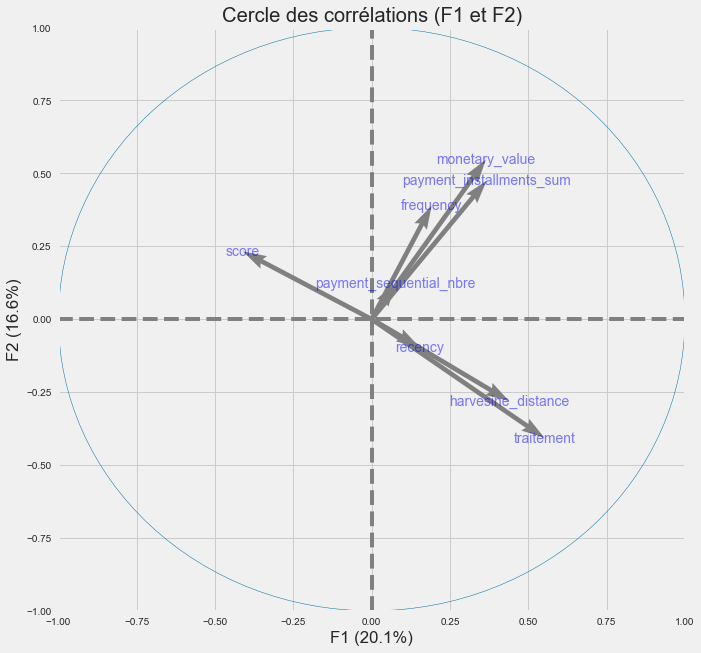

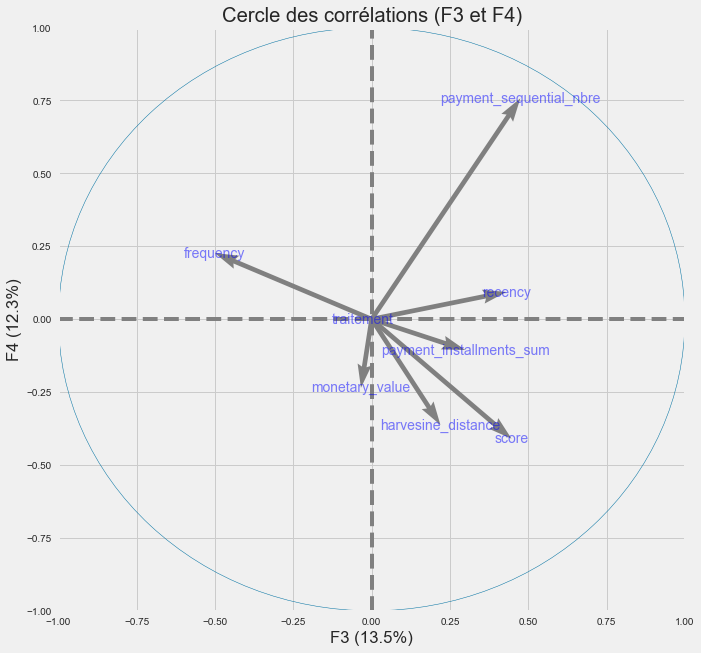

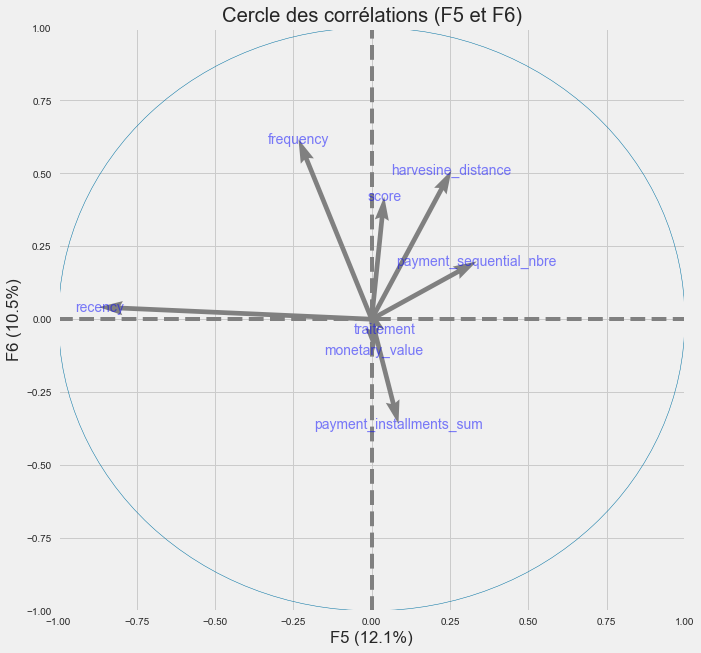

In [84]:
# Cercle des corrélations
n_comp=6
pca=pca2
features = X.columns
pcs = pca2.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))


Constatations : la durée de traitement d'une commande est fortement corrélée à la distance entre le HQ d'Olist et le domicile du client.  
La récence est également corrélée avec le traitement et la distance .Ces variables sont regroupées dans le 2eme cadran.  
monetary_value , frequency , la somme des paiements et le nombre de paiements sont également corrélés.Ces variables sont groupées dans le 1er cadran

Le traitement est la variable la plus corrélée avec la composante Principale 1 
Le score(note clients) est anti-corrélé a la PC1

On peut regarder le poids de chaque variable dans les composantes principales
Pour cela on crée un dataframe

In [85]:
weight2_pc = pd.DataFrame(pca2.components_,columns = acp_in2.columns[1:],
                         index=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"])
weight2_pc.index.name="Composante Principale"
weight2_pc  

,payment_sequential_nbre,payment_installments_sum,score,traitement,recency,frequency,monetary_value,harvesine_distance
Composante Principale,,,,,,,,
PC1,0.076229,0.367285,-0.410980,0.552149,0.153157,0.191429,0.364641,0.438695
PC2,0.122925,0.475298,0.232346,-0.407210,-0.095931,0.389130,0.547578,-0.280555
PC3,0.474731,0.299099,0.446554,-0.029715,0.429933,-0.500645,-0.034158,0.219597
PC4,0.757511,-0.105690,-0.409823,-0.000309,0.093381,0.226793,-0.235282,-0.362683
PC5,0.335371,0.085669,0.040078,0.041157,-0.870242,-0.233614,0.008060,0.254804
PC6,0.198156,-0.358829,0.419889,-0.035922,0.041474,0.616977,-0.107619,0.510311
PC7,0.166837,-0.622042,0.077720,0.168276,0.041349,-0.226345,0.692006,-0.138047
PC8,-0.017660,0.124617,0.475176,0.705073,-0.114138,0.152920,-0.141958,-0.452410


# 5. ACP avec jeux de données réduit à 4 variables numériques

#### 5.1  Préparation des données et calcul de l'ACP

In [86]:
acp_4v=df_4v.reset_index(drop=False)
# suppression des colonnes non numériques
X=acp_4v.select_dtypes(np.number)
#Je vais standardiser() centrer et réduire) mes données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
pca_4v = PCA()
pca_4v.fit(X_scaled)


PCA()

In [87]:
df_4v.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93082 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         93082 non-null  int64  
 1   frequency       93082 non-null  int64  
 2   monetary_value  93082 non-null  float64
 3   score           93082 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 3.6+ MB


#### 5.2 Calcul de la variance expliquée

In [88]:
resume_var = pd.DataFrame(
    {
        "Dimension" : ["PC" + str(x + 1) for x in range(len(pca_4v.explained_variance_))], 
        "Variance expliquée" : pca_4v.explained_variance_,
        "% variance expliquée" : np.round(pca_4v.explained_variance_ratio_ * 100,1),
        "% cum. var. expliquée" : np.round(np.cumsum(pca_4v.explained_variance_ratio_) * 100,1)
    }
)
resume_var

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,PC1,1.231665,30.8,30.8
1,PC2,1.002243,25.1,55.8
2,PC3,0.970743,24.3,80.1
3,PC4,0.795393,19.9,100.0


#### 5.3 Eboulis des valeurs propres

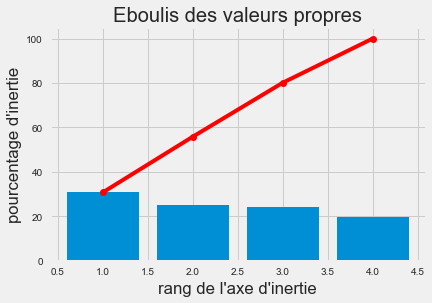

In [89]:
display_scree_plot(pca_4v)

#### 5.4 Représentation des individus

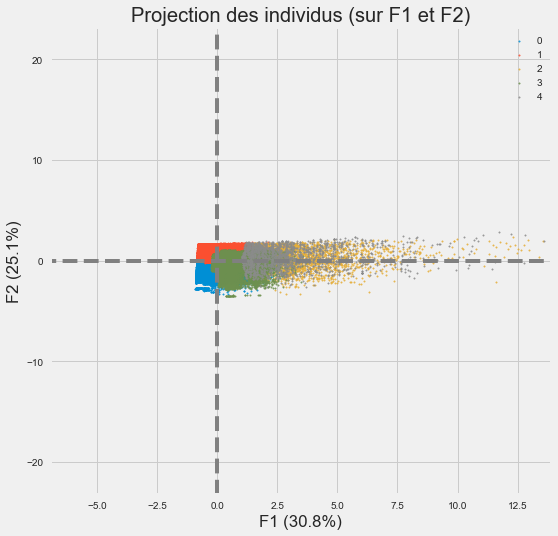

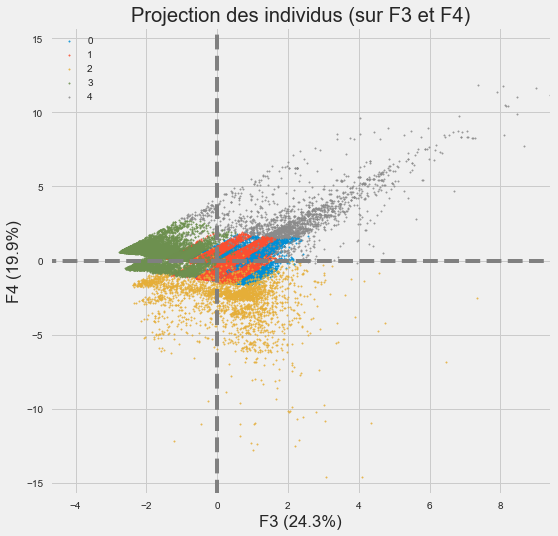

In [103]:
n_comp=4
X_projected = pca_4v.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca_4v, [(0,1),(2,3)], labels = None,illustrative_var=df_groupes_kmeans_4v['Groupe'])

plt.show()

In [ ]:
df_pca4v_4pc = pca_4v.transform(X_scaled)

In [ ]:
# Transformation en DataFrame pandas
df_pca4v_4pc = pd.DataFrame({
    "customer" : acp_4v["customer_unique_id"],
    "PC1" : df_pca_4v[:,0], 
    "PC2" : df_pca_4v[:,1],
    "PC3" : df_pca_4v[:,2],
    "PC4" : df_pca_4v[:,3],
   
})

# Résultat (premières lignes)
df_pca4v_4pc.head()

#### 5.5 Représentation des variables

In [ ]:
# Cercle des corrélations
n_comp=4
pca=pca_4v
features = X.columns
pcs = pca_4v.components_
display_circles(pcs, n_comp, pca_4v, [(0,1),(2,3)], labels = np.array(features))


Constat: la récence a très peu de poids sur la pc1 

In [ ]:
weight4v_pc = pd.DataFrame(pca_4v.components_,columns = acp_4v.columns[1:],
                         index=["PC1","PC2","PC3","PC4"])
weight4v_pc.index.name="Composante Principale"
weight4v_pc  

# 6. Conclusions

La segmentation client la plus pertinente est obtenue avec le k-means (k=5) appliqué sur le jeu de données réduit à 4 variables qui sont :
recency, frequency,monetary_value et score ( note de satisfaction client)

